# OLD: Notebook from July 2022
I used it for constructing the resampling technique required for the multi-timescale Data Assimilation

In [2]:
import sys
sys.path.append('/home/mchoblet/paleoda')


import xarray as xr
import numpy as np

import dataloader
import psm_pseudoproxy

import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import bisect

import cartopy.crs as ccrs
from scipy.stats import linregress
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature  

sns.set_style("darkgrid")


%cd /home/ldap-server/draco/notebooks/paleoda/paleoda/notebooks

/home/ldap-server/draco/notebooks/paleoda/paleoda
/home/ldap-server/draco/notebooks/paleoda/paleoda/notebooks


In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

In [4]:
%%javascript

Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('up');
Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('down');

<IPython.core.display.Javascript object>

In [5]:
%%time

def make_equidistant_target(data,target_time,target_res,method_interpol='nearest',filt=True,min_ts=1):
    """
    Takes a proxy timeseries "data" (fully resolved,with nans in between if no value available) and resamples it equidistantly to the (equidistant) target timeseries
    "target_time"  (DataArray(!) of cftime-objects, we need .dt.time.year accessor), which has the resolution "target_res" (consistency with target_time is not checked).
    We usualy set the target_res to the median resolution.
    
    The resampling procedure is adapted from the Paleospec R-package: https://github.com/EarthSystemDiagnostics/paleospec/blob/master/R/MakeEquidistant.R.
    The time resolution is based on yearly data. Other time resolution (monthly) would require adapting the filtering part.
    
    Code consists of the following steps.
        0. Duplicate first non-nan-data point if this required by target_time spacing
        1. Resample and interpolate time series to 'min_ts'-resolution (yearly makes sense in our case). Nearest neighbor interpolation!
        2. Low_pass filter resampled time_series (High order Butterworth filter used in R-package, I use filtfilt to avoid time lag)
        3. Resample to target resolution
    
    Comments:
        1. Be aware that some proxy records have huge jumps without data in between. The resampled values there are not meaningful and need to be masked separately.
        2. Use xarray > v2022.06.0 to make use of fast resampling operation (but slowness of old version not a problem for our time-lengths)
    
    Example:
        Given some time-series with measurements at time [4,9,14,19,24], which we treat as mean-values for the time range centered on these times.
        We want to resample it equidistanced for the times [0,5,10,15,20,25]. These target labels are actually the left edge of a time block 
        (in the DA we effectively reconstruct the mean of the years [[0,1,2,3,4],[5,6,7,8,9],[10,11,12,13,14],[15,16,17,18,19],[20,21,22,23,24]])
        Therefore when using the xarray resample method in the final step (down-sampling) it is important to set closed='left' (and eliminate the last element), so that it is logically consistent.

    """
    #drop nan entries in data, extract data which are not nan
    #without dropping nans interpolation wont work
    data=data.dropna('time')
    vals=data.values

    #time_values and years contained in original time_series
    time=data.time.values
    time_years=data.time.dt.year.values

    #For the first year included in proxy timeseries find the nearest year in target_time, which is smaller than the first year.
    #Repeat first data value and append this value and its time to the values. Do not do this if the first year is part of the target_time.

    first_year=time_years[0]
    target_years=target_time.time.dt.year.values

    #find by modulo calcuation and search sorted (could also create new Datetimeobject)
    start=first_year-first_year % target_res

    if start!=first_year:
        idx = np.searchsorted(target_years, start, side="left")
        time_add=target_time[idx].values

        #insert time and duplicate first value
        time=np.insert(time,0,time_add)
        vals=np.insert(vals,0,vals[0])

    vals_new=xr.DataArray(data=vals,coords=dict(time=time))

    #1. resampling (upsampling) and interpolating (upsampling)
    min_ts=str(min_ts)+'YS'
    upsampled=vals_new.resample(time=min_ts).interpolate(method_interpol)

    ##Fill nans
    #upsampled=upsampled.interpolate_na('time',method='linear')

    #2. LOW PASS FILTER for resampled time series (avoid aliasing)
    from scipy.signal import butter, lfilter, filtfilt

    def butter_lowpass(cutoff, fs, order=6, kf=1.2):
        # kf:  scaling factor for the lowpass frequency; 1 = Nyquist, 1.2 =
        #' 1.2xNyquist is a tradeoff between reducing variance loss and keeping
        #' aliasing small
        #fs is basic timestep (min_ts)
        #nyquist frequency
        nyq = 0.5 * fs 
        normal_cutoff = cutoff / nyq * kf
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def butter_lowpass_filter(data, cutoff, fs, order=6):
        #filtfilt does not introduce a time-lag in comparison to butterworth 
        b, a = butter_lowpass(cutoff, fs, order=order)
        y = filtfilt(b, a, data)
        #y = lfilter(b, a, data)
        return y

    cutoff=1/target_res
    fs=1 #yearly base frequency
    #pdb.set_trace()
    if filt==True:
        up_filt=butter_lowpass_filter(upsampled,cutoff,fs,order=4)
    else:
        up_filt=upsampled

    ###3. RESAMPLE TO TARGET RESOLUTION
    
    #string for resampled option 'YS': year start is very important
    target_res_st=str(target_res)+'YS'

    #convert up_filt to Dataarray in order to use resample method
    up_filt=xr.DataArray(up_filt, coords=dict(time=upsampled['time']))
    #pdb.set_trace()
    resampled=up_filt.resample(time=target_res_st,closed='left').mean('time')
    
    #reindex time to get back to the global full timescales (non existing values filled with nan)
    final=resampled.reindex(time=target_time)

    return final

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 2.86 µs


In [6]:
def mask_the_gap(resampled, original_ts, time_res,tol):
    """
    Input: 
        resampled: equidistant time-series (from proxy_db beginning to end, containing nans at beginning/start)
        time_res: Resolution of resampled time-series
        original_ts: original time_series of proxy from proxy_db-table (containing nans in between measurement if measurement not yearly)
        tol(erance): Integer, defines how many times the time_res a resampled measurement is allowed to be from an actual measurement. Tol=1: Just the actual timeslice
        for even time_res it takes one more time than it should (but makes sense)
        
    i+step+step_tol / i+step-step_tol necessary for original logic (time is labeled by left block end, but it means the mean of the block)
    """
    resampled=resampled.copy()
    
    resampled=resampled.dropna('time')
    resampled_time=resampled.time.values
    
    original_time=original_ts['time']
    length=len(original_time)
    original_year=original_time.dt.year.values
    step=time_res//2
    step_tol=tol*step
    
    #loop through resampled timeseries and check if there are nearby measurements
    for t,tt in enumerate(resampled_time):
        year=resampled_time[t].year
        #find index of t in original timeseries

        i=np.argwhere(original_year==year).tolist()[0][0]

        #special cases for borders
        if i+step-step_tol<0:
            l=len(original_ts.isel(time=slice(0,i+step+step_tol+1)).dropna('time'))        
        
        elif i+step+step_tol>length:
            l=len(original_ts.isel(time=slice(i+step-step_tol,length)).dropna('time'))        
        
        else:
            l=len(original_ts.isel(time=slice(i+step-step_tol,i+step+step_tol+1)).dropna('time'))        
        
        #alternative: via count_nonzero + np.isnan/np.
        #l=np.count_nonzero(~np.isnan(original_time.isel(time=slice(i-step_tol,i+step_tol+1))))
        if l==0:
            resampled.loc[dict(time=tt)]=np.nan
        
    return resampled

Problem with gap masking:

    - when using linear interpolation we get an illogic situation. We mask points in between large gaps, but points at the edge of the gap are kept, although their value is influenced by the value that is too far away.
    - It would probably be better to go through original time series:
        - calculate gap size
        - look for gaps which are too large. Use start/end - point of this gap
        - look for nearest point in resampled time series (time_res) to start/end, find their indices.
        - Starting from index +1 to index of end mask all points in resampled time series

- masking proxies this way will be slower (~0.5s per proxy), but makes more sense I guess



In [32]:
def mask_the_gap_alt(resampled_ts, original_ts, time_res,tol):
    """
    #Alternative way of masking gaps (It looks for gaps in the original timeseries and masks them in the resampled timeseries
    
    Input: 
        resampled: equidistant time-series (from proxy_db beginning to end, containing nans at beginning/start)
        time_res: Resolution of resampled time-series
        original_ts: original time_series of proxy from proxy_db-table (containing nans in between measurement if measurement not yearly)
        tol(erance): size of gap with respect to time_res (tol*time_res)
        
    """
    #copy
    resampled_ts=resampled_ts.copy()
    
    #maximum allowed gap
    max_gap=tol*time_res

    #screen original timeseries for jumps
    original_ts_years=original_ts.dropna('time').time.dt.year
    gaps=np.abs(np.array(original_ts_years)[1:]-np.array(original_ts_years)[:-1])

    #find index where gap > max_gap (left end)
    args=np.argwhere(gaps>max_gap).flatten()

    #select according years
    #starts=original_ts.dropna('time').time[args].dt.year
    #ends=original_ts.dropna('time').time[args+1].dt.year

    starts=original_ts_years[args]
    ends=original_ts_years[args+1]
    
    target_time_ts=resampled_ts['time']
    target_years_ts=resampled_ts['time'].dt.year

    #in target years, find the ones that are larger than start and smaller than end
    #bisectional search is the most efficient way, list comprehension would be orders of magnitude slower
    #we use bisect-righ for findin the elements (right/left indicates if index to right/left is chosen for equality)
    #For the end we keep the first to the left of the end (because it's influenced by the measurement to the right) and thus
    #select the penultimate one
    
    for ii,t in enumerate(starts):

        #find indices with bisect right
        start_idx=bisect.bisect_right(target_years_ts,starts[ii]) 

        #end index,-2 because slice also selects last element
        end_idx=bisect.bisect_right(target_years_ts,ends[ii])-2

        resampled_ts.loc[dict(time=slice(target_time_ts[start_idx],target_time_ts['time'][end_idx]))]=np.nan
        
    return resampled_ts



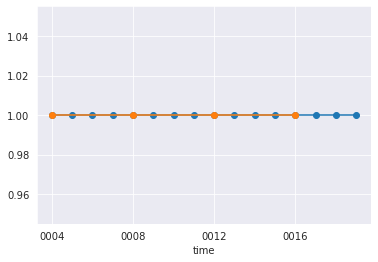

In [51]:
target_time=xr.DataArray(xr.cftime_range(start='0004',periods=16,freq='YS',calendar='365_day'),dims='time')
target_years=target_time.time.dt.year
test_array=xr.DataArray(np.ones(16),coords=dict(time=target_time))
test_array_res=test_array.resample(time='4YS',closed='left').mean()
target_time2=xr.DataArray(xr.cftime_range(start='0000',periods=6,freq='4YS',calendar='365_day'),dims='time')
target_years2=target_time2.dt.year

test_array.plot.line('o-')
test_array_res.plot.line('o-')
#I want to mask everything between 8 and 18 (-> so 12 and 16. Keep 8.)


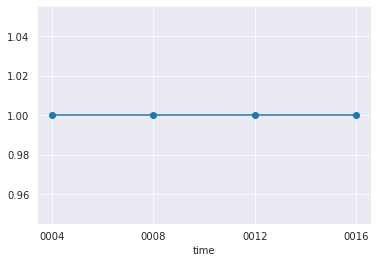

In [46]:
test_array_res.plot.line('o-')

In [52]:
test_array_res.reindex(time=target_time2)

<xarray.DataArray (time: 6)>
array([nan,  1.,  1.,  1.,  1., nan])
Coordinates:
  * time     (time) object 0000-01-01 00:00:00 ... 0020-01-01 00:00:00

In [35]:
test_array_res

<xarray.DataArray (time: 5)>
array([1., 1., 1., 1., 1.])
Coordinates:
  * time     (time) object 0003-12-31 00:00:00 ... 0019-12-31 00:00:00

In [13]:
new=make_equidistant_target(test_array,1,target_time2,target_res=4,method_interpol='nearest',filt=True)
new_time=new['time']

/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, method=method, tolerance=tolerance)
/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, method=method, tolerance=tolerance)


In [12]:
new.loc[dict(time=slice(new_time[0],new_time[1]))]=np.nan
new

<xarray.DataArray (time: 6)>
array([nan, nan,  1.,  1.,  1., nan])
Coordinates:
  * time     (time) object 0000-01-01 00:00:00 ... 0020-01-01 00:00:00

In [17]:
import bisect

In [31]:
new=make_equidistant_target(test_array,1,target_time2,target_res=4,method_interpol='nearest',filt=True)
new_time=new['time']

start,end=8,20
start_idx=bisect.bisect_right(target_years2,start) 

#end index, -1 because slice also selects last element
end_idx=bisect.bisect_right(target_years2,end)-2

new.loc[dict(time=slice(target_time2[start_idx],target_time2['time'][end_idx]))]=np.nan
new

/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, method=method, tolerance=tolerance)
/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, method=method, tolerance=tolerance)


<xarray.DataArray (time: 6)>
array([ 1.,  1.,  1., nan, nan, nan])
Coordinates:
  * time     (time) object 0000-01-01 00:00:00 ... 0020-01-01 00:00:00

In [27]:
new_time

<xarray.DataArray 'time' (time: 6)>
array([cftime.DatetimeNoLeap(0, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(4, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(8, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(12, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(16, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(20, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 0000-01-01 00:00:00 ... 0020-01-01 00:00:00

In [182]:
print(target_time2[3],target_time2[5])

<xarray.DataArray ()>
array(cftime.DatetimeNoLeap(12, 1, 1, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time     object 0012-01-01 00:00:00 <xarray.DataArray ()>
array(cftime.DatetimeNoLeap(20, 1, 1, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time     object 0020-01-01 00:00:00


In [179]:
print(target_time2)

<xarray.DataArray (time: 6)>
array([cftime.DatetimeNoLeap(0, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(4, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(8, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(12, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(16, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(20, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 0000-01-01 00:00:00 ... 0020-01-01 00:00:00


In [181]:
new.loc[dict(time=slice(target_time2[3],target_time2[5]))]==np.nan
print(new)

<xarray.DataArray (time: 6)>
array([ 1.,  1.,  1.,  1.,  1., nan])
Coordinates:
  * time     (time) object 0000-01-01 00:00:00 ... 0020-01-01 00:00:00


In [162]:
print(new.time)

<xarray.DataArray 'time' (time: 6)>
array([cftime.DatetimeNoLeap(0, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(4, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(8, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(12, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(16, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(20, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 0000-01-01 00:00:00 ... 0020-01-01 00:00:00


In [150]:
print(new)

<xarray.DataArray (time: 6)>
array([ 1.,  1.,  1.,  1.,  1., nan])
Coordinates:
  * time     (time) object 0000-01-01 00:00:00 ... 0020-01-01 00:00:00


In [157]:
years=new.time.dt.year
print(years[bisect.bisect_right(years,8)])
print(years[bisect.bisect_left(years,18)-1])

<xarray.DataArray 'year' ()>
array(12)
Coordinates:
    time     object 0012-01-01 00:00:00
<xarray.DataArray 'year' ()>
array(16)
Coordinates:
    time     object 0016-01-01 00:00:00


## BASIC TEST
- take a sinosidial signal with a period of 18
- resample the signal taking 5 year means, but centered around 3, 8, 13, 18
- further more we mask some values in between 

Mean of signal da from 1:6:  0.7640897325642125
Mean from resampling:  0.7640897325642125


Text(0.5, 1.0, 'Initial sine-signal which is averaged to 5 year means')

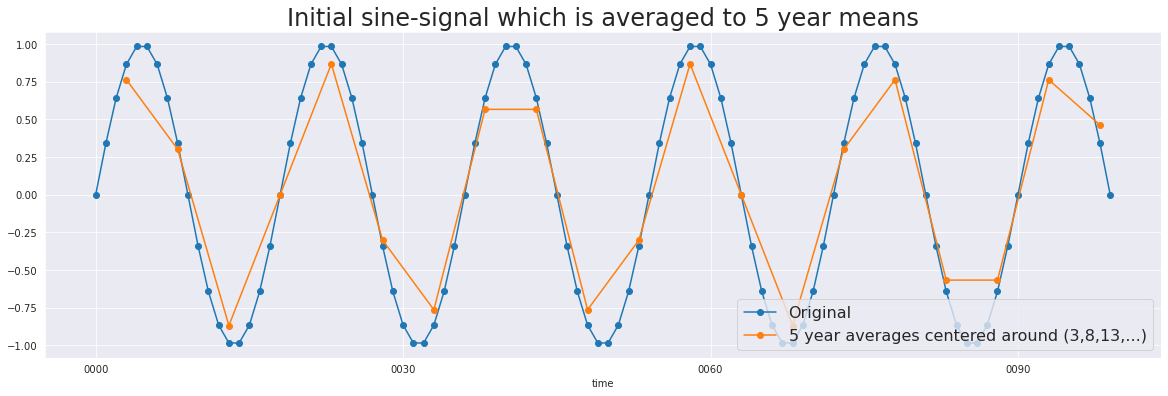

In [69]:
period=18

time=np.arange(0,100,1)

signal=np.sin(2*np.pi/period*time)
time_org=xr.cftime_range(start='0000',freq='YS',periods=100,calendar='365_day')
signal_da=xr.DataArray(data=signal,coords=(dict(time=time_org)))
plt.figure(figsize=(20,6))
signal_da.plot.line('o-',label='Original')

time_scale=5
time_str=str(time_scale)+'YS'
start=str(time_scale//2)+'YS'

signal_mean=signal_da[1:].resample(time=time_str,closed='left',loffset=start).mean()

print('Mean of signal da from 1:6: ',signal_da[1:6].mean().values.tolist())
print('Mean from resampling: ',signal_mean[0].values.tolist())

signal_mean=signal_mean.reindex(dict(time=time_org))


signal_mean.dropna('time').plot.line('o-',label='5 year averages centered around (3,8,13,...)')

plt.legend(fontsize=16,loc='lower right')
plt.title('Initial sine-signal which is averaged to 5 year means',fontsize=24)


Text(0.5, 1.0, '5 Year mean with missing values (centered around 3,8,13,...)')

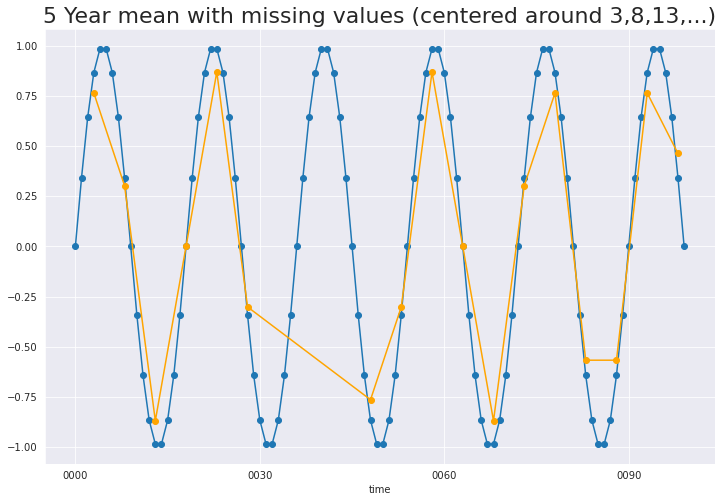

In [70]:
### Masking some  values in between: year 34,39,44
plt.figure(figsize=(12,8))
signal_da.plot.line('o-',label='Original')
signal_mean.loc[dict(time=signal_da['time'][[33,38,43]])]=np.nan
signal_mean.dropna('time').plot.line('o-',color='orange')

plt.title('5 Year mean with missing values (centered around 3,8,13,...)',fontsize=22)


In [71]:
target_time=xr.DataArray(data=xr.cftime_range(start='0000',freq='5YS',end='0095',calendar='365_day'),dims='time')
signal_mean_ed=make_equidistant_target(signal_mean,min_ts=1,target_time=target_time,target_res=5,method_interpol='nearest',filt=True)

#copy signal_mean_ed for adapting its time series
signal_mean_ed_2=signal_mean_ed.copy()


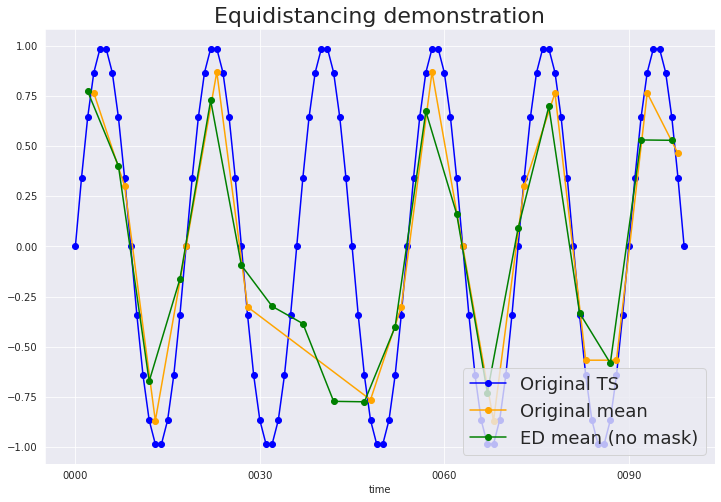

In [72]:
plt.figure(figsize=(12,8))
signal_da.plot.line('o-',color='blue',label='Original TS')
signal_mean.dropna('time').plot.line('o-',color='orange',label='Original mean')

#for plot of new mean to be plotted correctly we need to shift the time-axis
signal_mean_ed_2['time']=xr.DataArray(data=xr.cftime_range(start='0002',freq='5YS',end='0097',calendar='365_day'),dims='time')

signal_mean_ed_2.plot.line('o-',color='green',label='ED mean (no mask)')
#signal_mean_mask.plot.line('o-',color='darkgreen',label='New mean (with mask)')
plt.title('Equidistancing demonstration',fontsize=22)
plt.legend(fontsize=18,loc='lower right')

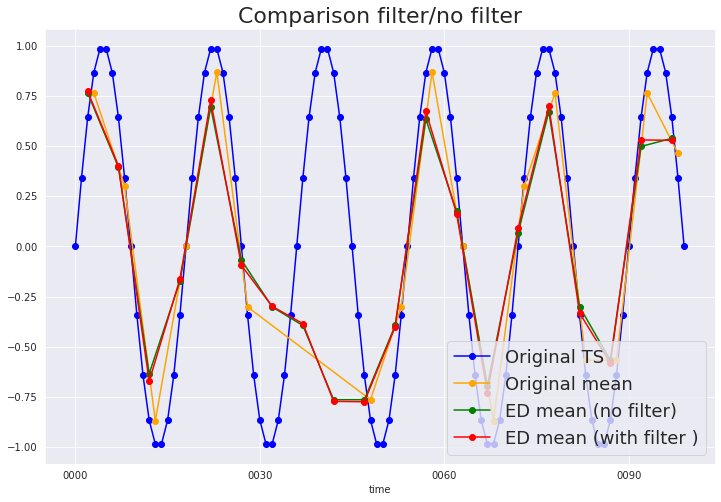

In [73]:
#plot without lowpass filter

signal_mean_ed=make_equidistant_target(signal_mean,min_ts=1,target_time=target_time,target_res=5,method_interpol='nearest',filt=False)

signal_mean_ed_3=signal_mean_ed.copy()

plt.figure(figsize=(12,8))
signal_da.plot.line('o-',color='blue',label='Original TS')
signal_mean.dropna('time').plot.line('o-',color='orange',label='Original mean')

#for plot of new mean to be plotted correctly we need to shift the time-axis
signal_mean_ed_3['time']=xr.DataArray(data=xr.cftime_range(start='0002',freq='5YS',end='0097',calendar='365_day'),dims='time')

signal_mean_ed_3.plot.line('o-',color='green',label='ED mean (no filter)')
signal_mean_ed_2.plot.line('o-',color='red',label='ED mean (with filter )')
#signal_mean_mask.plot.line('o-',color='darkgreen',label='New mean (with mask)')
plt.title('Comparison filter/no filter', fontsize=22)
plt.legend(fontsize=18,loc='lower right')

In [78]:
signal_mean_mask=mask_the_gap(signal_mean_ed,signal_mean,time_res=5,tol=2)

/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/plot/plot.py:442: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  primitive = ax.plot(xplt_val, yplt_val, *args, **kwargs)


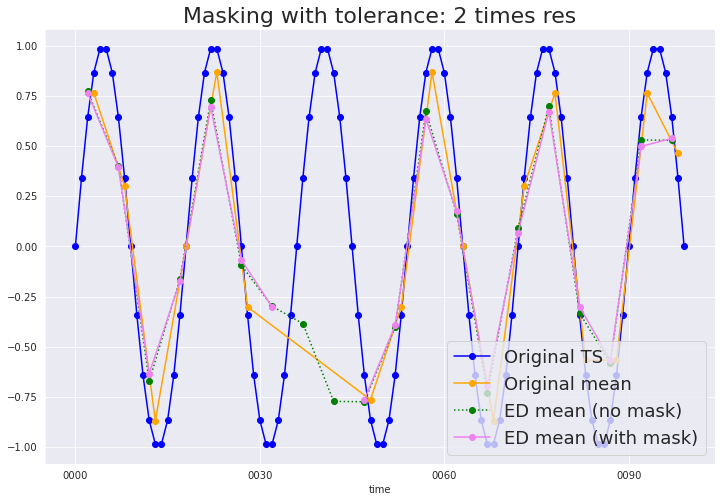

In [79]:
plt.figure(figsize=(12,8))
signal_da.plot.line('o-',color='blue',label='Original TS')
signal_mean.dropna('time').plot.line('o-',color='orange',label='Original mean')

#for plot of new mean to be plotted correctly we need to shift the time-axis
signal_mean_mask['time']=xr.DataArray(data=xr.cftime_range(start='0002',freq='5YS',end='0097',calendar='365_day'),dims='time')
signal_mean_ed_2.plot.line('o-',linestyle=':',color='green',label='ED mean (no mask)')
#signal_mean_ed.plot.line('o-',color='green',label='New mean')
signal_mean_mask.plot.line('o-',color='violet',label='ED mean (with mask)')
plt.title('Masking with tolerance: 2 times res', fontsize=22)
plt.legend(fontsize=18,loc='lower right')

### With linear interpolation instead of nearest 

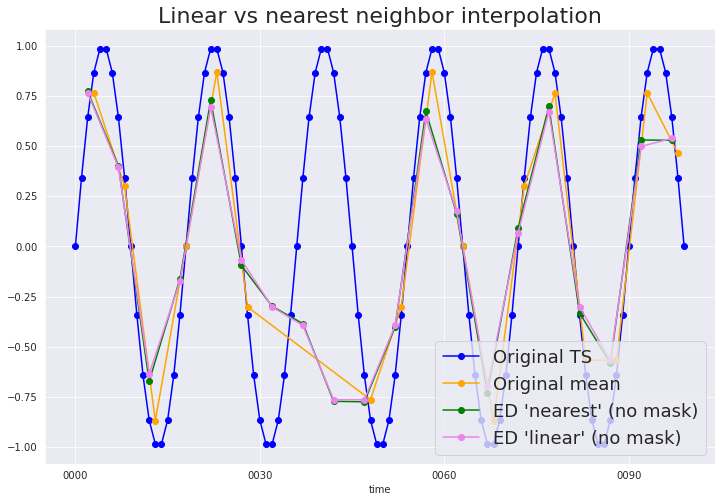

In [215]:
target_time=xr.DataArray(data=xr.cftime_range(start='0000',freq='5YS',end='0095',calendar='365_day'),dims='time')
signal_mean_lin=make_equidistant_target(signal_mean,min_ts=1,target_time=target_time,target_res=5,method_interpol='nearest',filt=True)

#copy signal_mean_ed for adapting its time series
signal_mean_lin_2=signal_mean_ed.copy()

plt.figure(figsize=(12,8))
signal_da.plot.line('o-',color='blue',label='Original TS')
signal_mean.dropna('time').plot.line('o-',color='orange',label='Original mean')

#for plot of new mean to be plotted correctly we need to shift the time-axis
signal_mean_ed_2['time']=xr.DataArray(data=xr.cftime_range(start='0002',freq='5YS',end='0097',calendar='365_day'),dims='time')
signal_mean_lin_2['time']=xr.DataArray(data=xr.cftime_range(start='0002',freq='5YS',end='0097',calendar='365_day'),dims='time')

signal_mean_ed_2.plot.line('o-',color='green',label='ED \'nearest\' (no mask)')

signal_mean_lin_2.plot.line('o-',color='violet',label='ED \'linear\' (no mask)')

#signal_mean_mask.plot.line('o-',color='darkgreen',label='New mean (with mask)')
plt.title('Linear vs nearest neighbor interpolation',fontsize=22)
plt.legend(fontsize=18,loc='lower right')


# Test make_equidistant_target  + mask_the_gap with proxy_dbs



In [24]:
iso_p='/home/ldap-server/draco/notebooks/paleoda/paleoda/proxy_dbs/final/iso2k_db.nc'

In [25]:
iso=xr.open_dataset(iso_p)['d18O']

In [26]:
%%time
target_res=20
freq=str(target_res)+'YS'
time_target=xr.DataArray(xr.cftime_range(start='0000',end='2014',freq=freq,calendar='365_day'),dims='time')


for s in iso.site:
    proxy=iso.sel(site=s)
    m=make_equidistant_target(proxy,1,time_target,target_res,method_interpol='nearest',filt=True)
    g=mask_the_gap(m,proxy,target_res,tol=2)

CPU times: user 3.97 s, sys: 24 ms, total: 4 s
Wall time: 4 s


In [8]:
sis_p='/home/ldap-server/draco/notebooks/paleoda/paleoda/proxy_dbs/final/sisal_db.nc'
sis=xr.open_dataset(sis_p)['d18O']

In [45]:
%%time
target_res=1
freq=str(target_res)+'YS'
time_target=xr.DataArray(xr.cftime_range(start='0000',end='2014',freq=freq,calendar='365_day'),dims='time')


for s in sis.site:
    proxy=sis.sel(site=s)
    m=make_equidistant_target(proxy,1,time_target,target_res,method_interpol='nearest',filt=False)
    g=mask_the_gap(m,proxy,target_res,tol=2)

CPU times: user 1min 32s, sys: 51.9 ms, total: 1min 32s
Wall time: 1min 32s


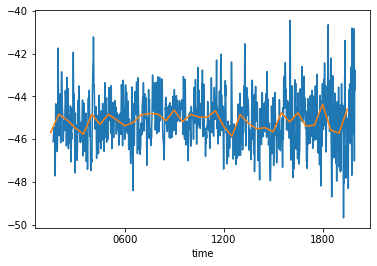

In [20]:
data.plot()
final.plot()

In [1330]:
%%timeit
upsampled=vals_new.resample(time=min_ts).interpolate(method_interpol)

/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, method=method, tolerance=tolerance)
/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, method=method, tolerance=tolerance)
/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, meth

32.6 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, method=method, tolerance=tolerance)
/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, method=method, tolerance=tolerance)
/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, meth

In [1329]:
%%timeit
resampled=up_filt.resample(time=target_res_st,closed='left').mean('time')

168 ms ± 100 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Test with Site 4 from Sisal
* location has really different time resolution through time
* the median resolution is 4
* first part coarsely resolved, second highly resolved
* we look at the effect of make equidistanced for both parts, here the difference between nearest neighbor interpolation and linear interpolation is clearly visible
* The steps introduced by nearest neighbor interpolation in the first part are maske


4.0
5


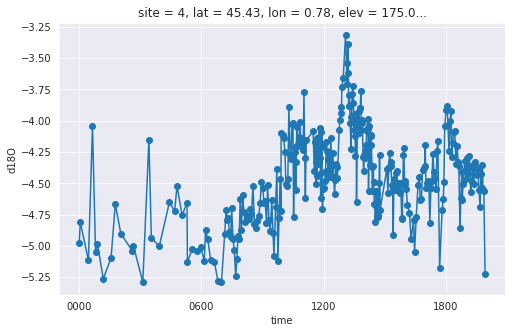

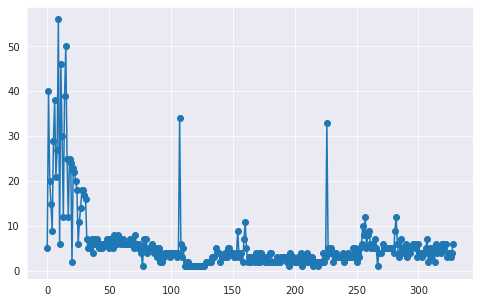

In [17]:
site_4=sis.sel(site=4)
site_4_year=site_4.dropna('time').time.dt.year
dist_right=np.abs(np.array(site_4_year)[1:]-np.array(site_4_year)[:-1])
med=np.median(dist_right)
#in case of equality
med=np.ceil(med)
print(med)


#must me a sorted list!
target_res_a=[1,5,10,25,50]
target_res_a=np.sort(target_res_a)


gaps=np.abs(np.array(site_4_year)[1:]-np.array(site_4_year)[:-1])


#find the target_resolution which is closest to median and larger than med -> use bisect method

import bisect
i=bisect.bisect_left(target_res_a,med)
med=target_res_a[i]
print(med)
plt.figure(figsize=(8,5))
site_4.dropna('time').plot.line('o-')
plt.show()
plt.figure(figsize=(8,5))
plt.plot(gaps,'o-')

### First part from 0 to 500

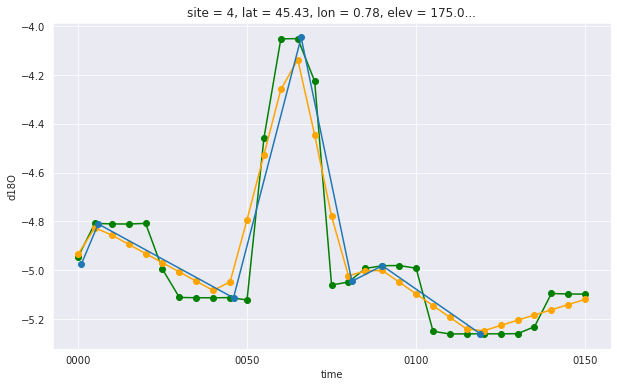

In [63]:
#target_resolution
freq=str(med)+'YS'
time_target=xr.DataArray(xr.cftime_range(start='0000',end='2012',freq=freq,calendar='365_day'),dims='time')

site_4_ed=make_equidistant_target(site_4,1,time_target,med,method_interpol='linear',filt=True)
site_4_ed_near=make_equidistant_target(site_4,1,time_target,med,method_interpol='nearest',filt=True)


plt.figure(figsize=(10,6))
site_4_ed_near.sel(time=slice('0000','0150')).dropna('time').plot.line('o-',color='green')
site_4_ed.sel(time=slice('0000','0150')).plot.line('o-',color='orange')
site_4.sel(time=slice('0000','0150')).dropna('time').plot.line('o-')

#site_4:.dropna('time').plot.line('o-')


/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/plot/plot.py:442: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  primitive = ax.plot(xplt_val, yplt_val, *args, **kwargs)
/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/plot/plot.py:442: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  primitive = ax.plot(xplt_val, yplt_val, *args, **kwargs)


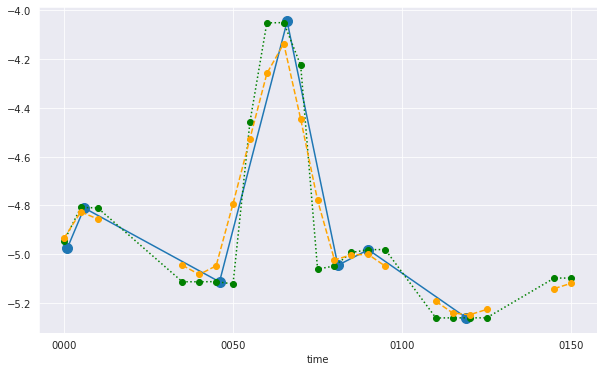

In [65]:
###masking gaps

site_4_ed_2=mask_the_gap(resampled=site_4_ed,original_ts=site_4,time_res=med,tol=5)
site_4_ed_near_2=mask_the_gap(resampled=site_4_ed_near,original_ts=site_4,time_res=med,tol=5)

plt.figure(figsize=(10,6))


site_4.sel(time=slice('0000','0150')).dropna('time').plot.line('o-',markersize=10)
site_4_ed_near_2.sel(time=slice('0000','0150')).dropna('time').plot.line('o-',color='green',linestyle=':')
site_4_ed_2.sel(time=slice('0000','0150')).plot.line('o-',color='orange',linestyle='--')


/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/plot/plot.py:442: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  primitive = ax.plot(xplt_val, yplt_val, *args, **kwargs)
/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/plot/plot.py:442: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  primitive = ax.plot(xplt_val, yplt_val, *args, **kwargs)


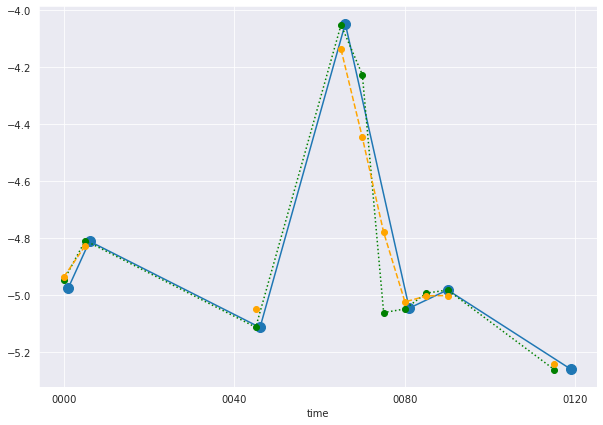

In [62]:
###masking gaps alternatively

#the critical point for the first gap is 40 years, thus 8*5, with a tolerance of 7 values should not appear any longer

site_4_ed_2=mask_the_gap_alt(resampled_ts=site_4_ed,original_ts=site_4,time_res=med,tol=3)
site_4_ed_near_2=mask_the_gap_alt(resampled_ts=site_4_ed_near,original_ts=site_4,time_res=med,tol=3)

plt.figure(figsize=(10,7))


site_4.sel(time=slice('0000','0150')).dropna('time').plot.line('o-',markersize=10)
site_4_ed_near_2.sel(time=slice('0000','0150')).dropna('time').plot.line('o-',color='green',linestyle=':')
site_4_ed_2.sel(time=slice('0000','0150')).plot.line('o-',color='orange',linestyle='--')

### Time from 800 to 1300
- we see that both interpolation approaches in this region smoothen out the peaks (due to the resampling)
- linear interpol smooths the extremes a bit more, but not so much also, so probably it is a good tradeoff, especially for the regions like above with not so much 
proxies -> Caveat: Masking for linear interpolation does not make so much sense. The points that we keep are still influenced by the point which is far off. So nearest neighbor interpolation is not so bad.

/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/plot/plot.py:442: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  primitive = ax.plot(xplt_val, yplt_val, *args, **kwargs)
/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/plot/plot.py:442: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  primitive = ax.plot(xplt_val, yplt_val, *args, **kwargs)


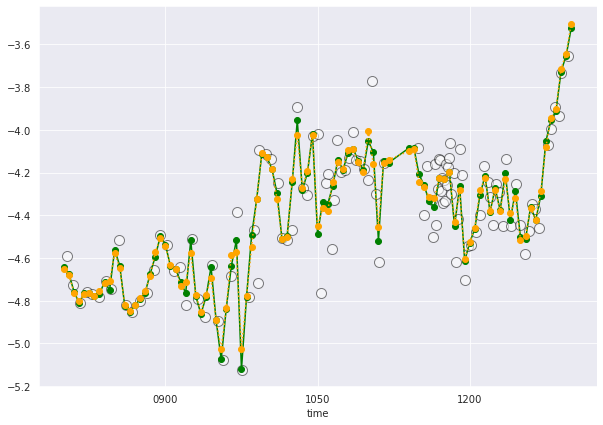

In [67]:
plt.figure(figsize=(10,7))


site_4.sel(time=slice('0800','1300')).dropna('time').plot.line('o-',linestyle='None',alpha=0.5,markersize=10,color='white',markeredgecolor='black')
site_4_ed_near_2.sel(time=slice('0800','1300')).dropna('time').plot.line('o-',color='green')
site_4_ed_2.sel(time=slice('0800','1300')).dropna('time').plot.line('o-',color='orange',linestyle=':')



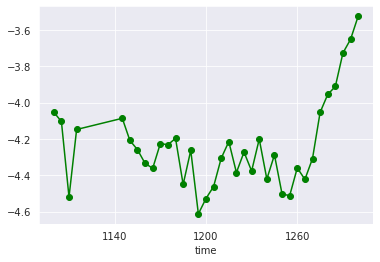

In [64]:
site_4_ed_near_2.sel(time=slice('1100','1300')).dropna('time').plot.line('o-',color='green')

In [386]:
np.diff(site_4.dropna('time').time.dt.year)

array([ 5, 40, 20, 15,  9, 29, 38, 21, 27, 56,  6, 46, 30, 12, 39, 50, 25,
       12, 25, 24,  2, 23, 22, 20, 18,  6, 11, 14, 18, 18, 17, 16,  7,  5,
        5,  6,  7,  4,  7,  6,  7,  6,  5,  6,  5,  6,  6,  6,  7,  7,  5,
        7,  6,  5,  8,  7,  6,  8,  7,  7,  6,  7,  6,  6,  6,  6,  6,  7,
        7,  6,  5,  8,  6,  5,  6,  5,  4,  1,  7,  5,  7,  4,  5,  5,  5,
        6,  4,  5,  5,  3,  5,  2,  4,  2,  3,  4,  4,  4,  4,  3,  4,  4,
        4,  4,  4,  3,  4, 34,  6,  3,  5,  1,  2,  1,  2,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,
        5,  4,  4,  4,  2,  3,  3,  3,  4,  3,  5,  5,  4,  4,  4,  3,  3,
        4,  9,  3,  4,  4,  2,  7, 11,  5,  2,  3,  3,  2,  3,  3,  2,  4,
        2,  4,  2,  4,  3,  3,  2,  2,  3,  2,  4,  4,  2,  2,  2,  2,  3,
        2,  2,  3,  3,  3,  3,  3,  2,  1,  4,  2,  3,  3,  2,  2,  2,  3,
        3,  4,  1,  3,  3,  2,  4,  2,  3,  3,  3,  1,  2,  2,  2,  1,  2,
        2,  2,  4,  2,  3

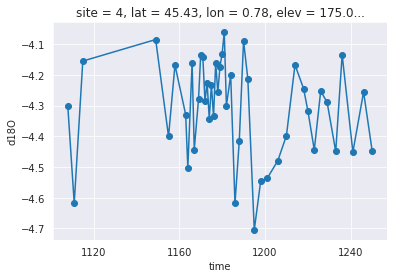

In [392]:
site_4.dropna('time')[105:150].plot.line('o-')

/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/plot/plot.py:442: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  primitive = ax.plot(xplt_val, yplt_val, *args, **kwargs)
/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/plot/plot.py:442: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  primitive = ax.plot(xplt_val, yplt_val, *args, **kwargs)


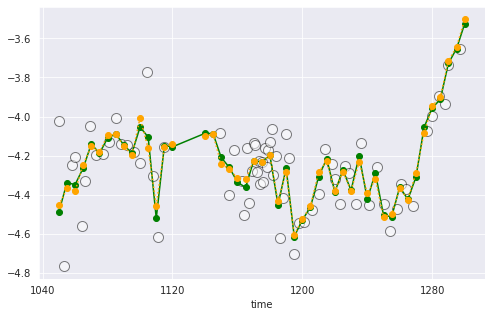

In [378]:
##masking

plt.figure(figsize=(8,5))

#0800
site_4.sel(time=slice('1050','1300')).dropna('time').plot.line('o-',linestyle='None',alpha=0.5,markersize=10,color='white',markeredgecolor='black')
site_4_ed_near_2.sel(time=slice('1050','1300')).dropna('time').plot.line('o-',color='green')
site_4_ed_2.sel(time=slice('1050','1300')).plot.line('o-',color='orange',linestyle=':')


# Old test stuff

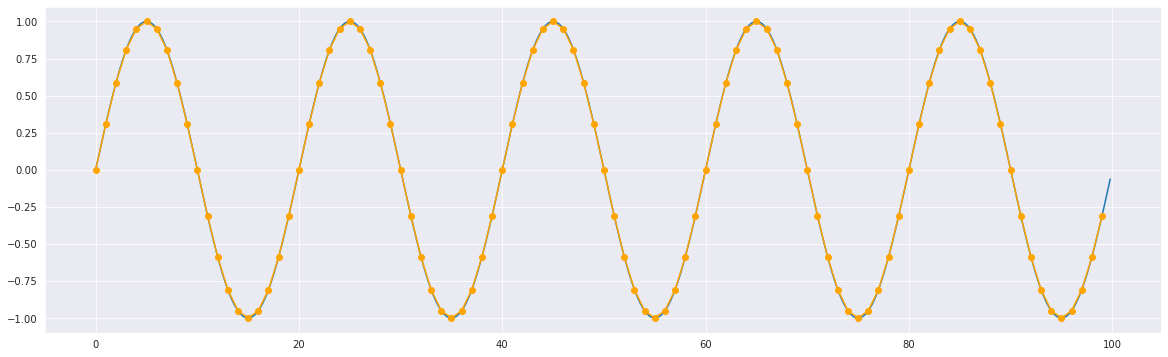

In [25]:
#### MAKE EQUIDISTANT
"""
test with a sinus signal that has a period of, e.g. 10 years
"""
period=20
sns.set_style("darkgrid")

time=np.arange(0,100,0.2)

signal=np.sin(2*np.pi/period*time)
plt.figure(figsize=(20,6))
plt.plot(time,signal,'-',label='Original signal')

#base_res sampling
base_res=1
time_y=np.arange(0,100,base_res)

signal=np.sin(2*np.pi/period*time_y)
plt.plot(time_y,signal,'o-',color='orange',label='Original signal')


In [34]:
#resample with 10 times the resolution
time=xr.cftime_range(start='0000',end='0099',freq='YS',calendar='365_day')

signal_da=xr.DataArray(data=signal,coords=dict(time=time))


In [39]:
resample_ts=5
string=str(resample_ts)+'Y'
resampled=signal_da.resample(time=string).mean()

For 5Y resampling, the resample function lets the first value untouched, then averages [1:6], [6:11], [11:16] ...

-> _Better choose closed='left' (and adapt time-index) to get what we want_

In [48]:
print(signal_da[1:6].mean().values)
resampled


0.7313751514675043


<xarray.DataArray (time: 21)>
array([ 0.        ,  0.73137515,  0.53137515, -0.73137515, -0.53137515,
        0.73137515,  0.53137515, -0.73137515, -0.53137515,  0.73137515,
        0.53137515, -0.73137515, -0.53137515,  0.73137515,  0.53137515,
       -0.73137515, -0.53137515,  0.73137515,  0.53137515, -0.73137515,
       -0.66421894])
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 0100-12-31 00:00:00

In [93]:
len(time_y)

34

In [97]:
time_

0.3333333333333333

In [ ]:
signal_

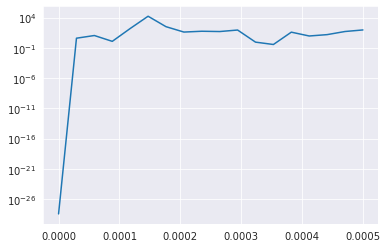

In [113]:
#power spectral densitya
fs=0.001
f, Pxx_den=signal.periodogram(signal_y, fs)
plt.semilogy(f, Pxx_den)


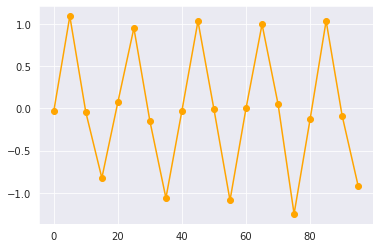

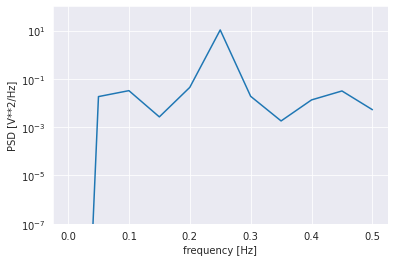

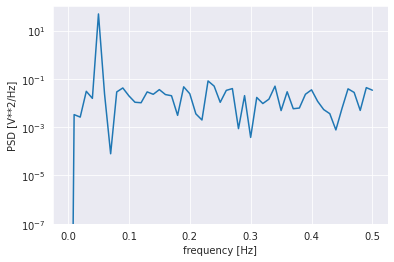

In [127]:
from scipy import signal

#base_res sampling

base_res=5
freq=1/base_res
time_y=np.arange(0,100,base_res)

#sinus signal has 1/20

signal_y=np.sin(2*np.pi*(1/20)*time_y)
noise_power = 0.01

signal_y += rng.normal(scale=np.sqrt(noise_power), size=time_y.shape)


plt.plot(time_y,signal_y,'o-',color='orange',label='Original signal')

#resample with 10 times the resolution
time=xr.cftime_range(start='0000',end='0099',freq='5YS',calendar='365_day')

signal_da_5=xr.DataArray(data=signal_y,coords=dict(time=time))

#signal_da_5.plot()

plt.show()

#power spectral densitya
fs=1
f, Pxx_den=signal.periodogram(signal_da_5.dropna('time').values, fs)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

#perfect spectrum
#power spectral densitya
fs=1
s=np.sin(2*np.pi*(1/20)*np.arange(100))
s += rng.normal(scale=np.sqrt(noise_power), size=100)
f, Pxx_den=signal.periodogram(s, fs)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()




/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, method=method, tolerance=tolerance)
/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, method=method, tolerance=tolerance)


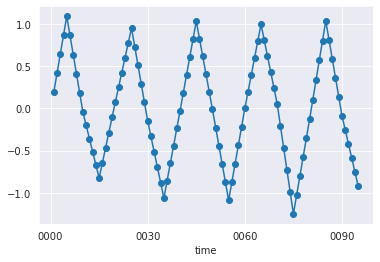

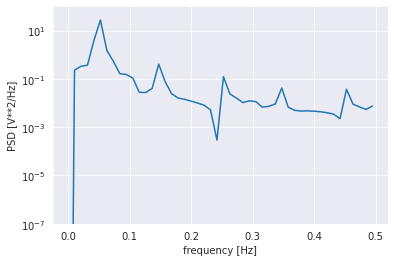

In [179]:
#resample to yearly data


signal_da_5_res=signal_da_5.resample(time='Y').interpolate()
signal_da_5_res.plot.line('o-')
plt.show()
#power spectral densitya
fs=1
f, Pxx_den=signal.periodogram(signal_da_5_res.dropna('time').values, fs)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [180]:
signal_da_5_res

<xarray.DataArray (time: 96)>
array([ 1.93120734e-01,  4.18427456e-01,  6.43734177e-01,  8.69040899e-01,
        1.09434762e+00,  8.67578136e-01,  6.39566684e-01,  4.11555232e-01,
        1.83543780e-01, -4.44676715e-02, -2.00694053e-01, -3.56723223e-01,
       -5.12752393e-01, -6.68781563e-01, -8.24810732e-01, -6.45663483e-01,
       -4.65595419e-01, -2.85527355e-01, -1.05459291e-01,  7.46087725e-02,
        2.50519217e-01,  4.26418240e-01,  6.02317262e-01,  7.78216285e-01,
        9.54115307e-01,  7.34292195e-01,  5.13381935e-01,  2.92471675e-01,
        7.15614143e-02, -1.49348846e-01, -3.32064229e-01, -5.14674682e-01,
       -6.97285134e-01, -8.79895587e-01, -1.06250604e+00, -8.56071500e-01,
       -6.48568155e-01, -4.41064811e-01, -2.33561467e-01, -2.60581223e-02,
        1.86368094e-01,  3.98807835e-01,  6.11247576e-01,  8.23687317e-01,
        1.03612706e+00,  8.27707411e-01,  6.18131557e-01,  4.08555702e-01,
        1.98979848e-01, -1.05960067e-02, -2.26395309e-01, -4.42211709e-01,
       -6.58028109e-01, -8.73844509e-01, -1.08966091e+00, -8.72557695e-01,
       -6.54265141e-01, -4.35972588e-01, -2.17680034e-01,  6.12519287e-04,
        2.00307386e-01,  3.99951160e-01,  5.99594934e-01,  7.99238709e-01,
        9.98882483e-01,  8.10551936e-01,  6.21155525e-01,  4.31759115e-01,
        2.42362705e-01,  5.29662944e-02, -2.07621548e-01, -4.68404971e-01,
       -7.29188395e-01, -9.89971818e-01, -1.25075524e+00, -1.02740629e+00,
       -8.02727310e-01, -5.78048328e-01, -3.53369345e-01, -1.28690363e-01,
        1.04850448e-01,  3.38415604e-01,  5.71980761e-01,  8.05545917e-01,
        1.03911107e+00,  8.15228849e-01,  5.90089902e-01,  3.64950954e-01,
        1.39812006e-01, -8.53269412e-02, -2.52094528e-01, -4.18701754e-01,
       -5.85308981e-01, -7.51916207e-01, -9.18523433e-01,             nan])
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 0095-12-31 00:00:00

In [322]:
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5, kf=1.2):
    # kf:  scaling factor for the lowpass frequency; 1 = Nyquist, 1.2 =
    #' 1.2xNyquist is a tradeoff between reducing variance loss and keeping
    #' aliasing small
    #fs is basic timestep (min_ts)
    #nyquist frequency
    nyq = 0.5 * fs 
    #normal nyquist freq by order
    
    normal_cutoff = cutoff / nyq * kf
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [536]:
#if the median resolution is 1 we do not need to use this:

def make_equidistant(data, min_ts=1, target=5):
    """
    Adapted to Python from: https://github.com/EarthSystemDiagnostics/paleospec/blob/master/R/MakeEquidistant.R
    Takes a Proxy Timeseries (as a DataArray) and makes it equidistant.
    Data is processed in 3 steps:
        1. Resample and interpolate time series to 'min_ts' ()
        2. Low_pass filter resampled time_series (High order Butterworth filter)
        3. Resample to 'target' resolution
    
    Be aware that some proxy records have huge jumps without data in between.
    Think about masking these datapoints.
    """
    #1. resampling and interpolating (upsampling)
    min_ts=str(min_ts)+'Y'
    data_res=data.resample(time='Y').interpolate('linear')

    #non_existing values are resampled to nans -> interpolate_na method
    data_res=data_res.interpolate_na('time',method='linear')

    #2. Low pass filter
    from scipy.signal import butter, lfilter, freqz

    def butter_lowpass(cutoff, fs, order=6, kf=1.2):
        # kf:  scaling factor for the lowpass frequency; 1 = Nyquist, 1.2 =
        #' 1.2xNyquist is a tradeoff between reducing variance loss and keeping
        #' aliasing small
        #fs is basic timestep (min_ts)
        #nyquist frequency
        nyq = 0.5 * fs 
        normal_cutoff = cutoff / nyq * kf
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def butter_lowpass_filter(data, cutoff, fs, order=4):
        b, a = butter_lowpass(cutoff, fs, order=order)
        y = lfilter(b, a, data)
        return y

    cutoff=1/target
    fs=1
    data_res_l=butter_lowpass_filter(data_res,cutoff,fs)

    target=str(target)+'Y'

    ###data_res needs to be dataarray with time_axis to be resampled
    #data_res.dropna('time').time
    data_res_l=xr.DataArray(data_res_l, coords=dict(time=data_res['time']))

    data_res_fin=data_res_l.resample(time=target).mean('time')    
    return data_res_fin


def mask_gap(data,data_original,time_res,scale=5):
    """
    Function that masks timeseries according to original dataseries if a jump is larger than scale * time_res.
    Time_res is the resolution the time_serief from data_orignal has been equidistant to.
    returns data with masked entries
    #scale parameter needs to be odd!
    
    """
    if scale//2!=1: print('Acceptable time range must be an odd number')
    range_x=scale
    r=(range_x-1)/2
    
    bubul=data.copy()
    
    time_str=str(time_res)+'Y'

    data_nan_res=data_nan.resample(time=time_str).mean()

    nan_times=data_nan_res.where(data_nan_res.isnull()==True,drop=True).time
    
    
    for i in nan_times.values:
        time_vals=data_nan_res['time'].values
        l=len(time_vals)
        b=np.argwhere(time_vals==i).tolist()[0][0]
        
        #adapt max and min index if the nan is near beginning/end of proxy ts
        min_i=int(b-r)
        max_i=int(b+r)+1
        if min_i<0:
            min_i=0
        if max_i>l:
            max_i=-1
        
        
        if int(b-r)>=0 and int(b+r)<=l:
            #if len(data_nan_res.isel(time=slice(int(b-r),int(b+r)+1)).dropna('time'))==0:
            if len(data_nan_res[min_i:max_i].dropna('time'))==0:
                bubul.loc[dict(time=time_vals[b])]=np.nan
            else:
                pass
                #print('not mask',b)


    
    return bubul
    
    
    
    
    

<xarray.DataArray (time: 8)>
array([-0.75260949,  1.38881187, -0.46976678,  1.67165458, -0.24899936,
        1.80957929, -0.13184207,  1.92673657])
Coordinates:
  * time     (time) object 0006-12-31 00:00:00 ... 0034-12-31 00:00:00


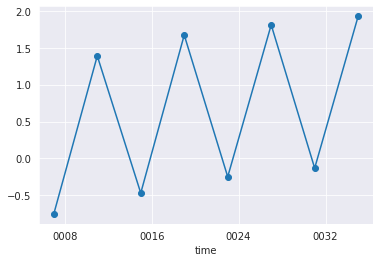

<xarray.DataArray (time: 10)>
array([       nan,        nan, 0.31810119, 0.45952254, 0.6009439 ,
       0.71132761, 0.78028996, 0.83886861, 0.89744725,        nan])
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 0036-12-31 00:00:00
<xarray.DataArray (time: 10)>
array([        nan,         nan, -0.75260949,  1.38881187, -0.46976678,
        1.67165458, -0.24899936,  1.80957929, -0.13184207,         nan])
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 0036-12-31 00:00:00


/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, method=method, tolerance=tolerance)
/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, method=method, tolerance=tolerance)
/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, meth

In [603]:
"""
Given a time series that has entries for time 6,10,14,18 ... (assuming it has already been resampled to this)
How to we bring it to a time series 0,4,8,12,16 ...

"""
data_small=data_nan[[6,10,14,18,22,26,30,34]] #len 8
print(data_small)
target_time=xr.cftime_range(start='0000',end='0040', freq='4Y',calendar='365_day') # len 9
data_small.plot.line('o-')
plt.show()
print(data_small.interp(time=target_time,method='linear'))
print(data_small.interp(time=target_time,method='nearest'))

In [605]:
data_small.resample(time='1Y').interpolate('linear')

/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, method=method, tolerance=tolerance)
/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, method=method, tolerance=tolerance)


<xarray.DataArray (time: 29)>
array([-0.75260949, -0.21725415,  0.31810119,  0.85345653,  1.38881187,
        0.9241672 ,  0.45952254, -0.00512212, -0.46976678,  0.06558856,
        0.6009439 ,  1.13629924,  1.67165458,  1.19149109,  0.71132761,
        0.23116413, -0.24899936,  0.2656453 ,  0.78028996,  1.29493462,
        1.80957929,  1.32422395,  0.83886861,  0.35351327, -0.13184207,
        0.38280259,  0.89744725,  1.41209191,  1.92673657])
Coordinates:
  * time     (time) object 0006-12-31 00:00:00 ... 0034-12-31 00:00:00

In [616]:
"""
Second try: proxy_timeseries has nans already dropped.
#add nearest times from target to start and end
"""

start=data_small.time[0]
end=data_small.time[-1]
target_time_da=xr.DataArray(target_time,dims='time')
data_small_res=data_small.resample(time='1Y').interpolate('linear')



/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, method=method, tolerance=tolerance)
/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, method=method, tolerance=tolerance)


In [923]:
6%4

2

2

In [935]:
signal_da_mean

<xarray.DataArray (time: 20)>
array([ 0.53137515,  0.73137515, -0.53137515, -0.73137515,  0.53137515,
        0.73137515, -0.53137515, -0.73137515,  0.53137515,  0.73137515,
       -0.53137515, -0.73137515,  0.53137515,  0.73137515, -0.53137515,
       -0.73137515,  0.53137515,  0.73137515, -0.53137515, -0.73137515])
Coordinates:
  * time     (time) object 0007-12-31 00:00:00 ... 0102-12-31 00:00:00

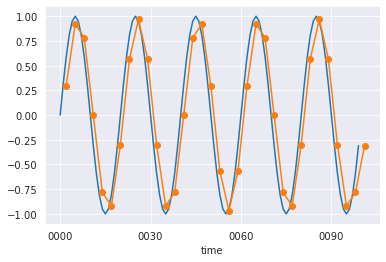

In [952]:
signal_da_mean=signal_da.resample(time='3Y',closed='left',loffset='0Y').mean()
#correct time
correct_time=xr.cftime_range(start='0001',freq='3Y',periods=len(signal_da_mean.time),calendar='365_day')
signal_da_mean['time']=correct_time

signal_da.plot()
signal_da_mean.plot.line('o-')

In [974]:
signal_da_mean_res.resample(time='3Y',closed='right').mean()

<xarray.DataArray (time: 34)>
array([ 0.29893408,  0.71299436,  0.82842123,  0.2608732 , -0.52174639,
       -0.87422286, -0.50596422,  0.27942625,  0.83444948,  0.70152795,
       -0.00975392, -0.71299436, -0.82842123, -0.2608732 ,  0.52174639,
        0.87422286,  0.50596422, -0.27942625, -0.83444948, -0.70152795,
        0.00975392,  0.71299436,  0.82842123,  0.2608732 , -0.52174639,
       -0.87422286, -0.50596422,  0.27942625,  0.83444948,  0.70152795,
       -0.00975392, -0.71299436, -0.82842123, -0.46688453])
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 0100-12-31 00:00:00

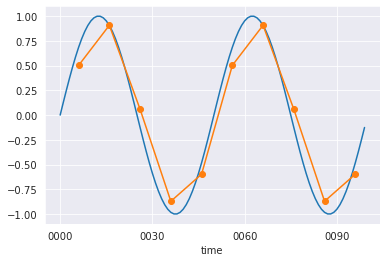

In [1006]:
period=50
sns.set_style("darkgrid")

time=np.arange(0,100,1)

freq=10
start='000'+str(freq//2)
freq_st=str(freq)+'Y'

signal=np.sin(2*np.pi/period*time)

#resample with 10 times the resolution
time=xr.cftime_range(start='0000',end='0099',freq='YS',calendar='365_day')

signal_da=xr.DataArray(data=signal,coords=dict(time=time))

signal_da_mean=signal_da.resample(time=freq_st,closed='left',loffset='0Y').mean()
#correct time
correct_time=xr.cftime_range(start=start,freq=freq_st,periods=len(signal_da_mean.time),calendar='365_day')
signal_da_mean['time']=correct_time

signal_da.plot()
signal_da_mean.plot.line('o-')


/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, method=method, tolerance=tolerance)
/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, method=method, tolerance=tolerance)
/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, meth

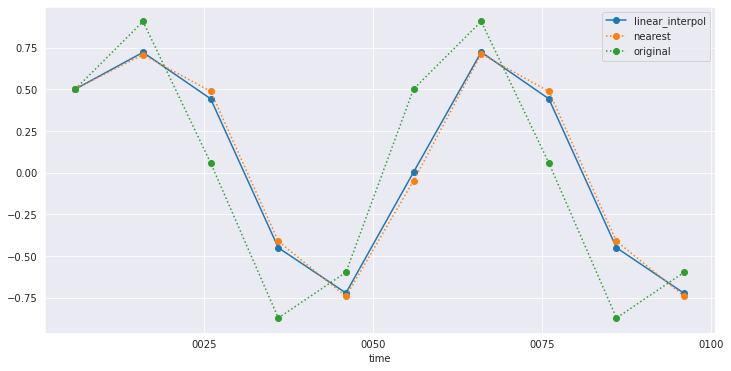

In [1007]:
plt.figure(figsize=(12,6))
signal_da_mean_res=signal_da_mean.resample(time='Y').interpolate('linear')

cutoff=1/freq
fs=1 #ground frequency is yealry
signal_da_mean_res_l=butter_lowpass_filter(signal_da_mean_res,cutoff,fs,order=2)

signal_da_mean_res_l=xr.DataArray(data=signal_da_mean_res_l,coords=(dict(time=signal_da_mean_res.time)))

signal_da_mean_res_l.resample(time=freq_st,closed='right').mean().plot.line('o-',label='linear_interpol')

#nearest neighbor interpolation
signal_da_mean_res=signal_da_mean.resample(time='Y').interpolate('nearest')

cutoff=1/freq
fs=1 #ground frequency is yealry
signal_da_mean_res_l=butter_lowpass_filter(signal_da_mean_res,cutoff,fs,order=2)

signal_da_mean_res_l=xr.DataArray(data=signal_da_mean_res_l,coords=(dict(time=signal_da_mean_res.time)))
signal_da_mean_res_l.resample(time=freq_st,closed='right').mean().plot.line('o-',label='nearest',linestyle=':')

signal_da_mean.plot.line('o-',linestyle=':',label='original')
plt.legend()


/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, method=method, tolerance=tolerance)
/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, method=method, tolerance=tolerance)


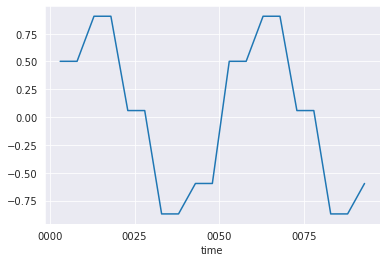

In [1002]:
signal_da_mean
signal_da_mean_res.resample(time='5Y').interpolate('linear').plot()

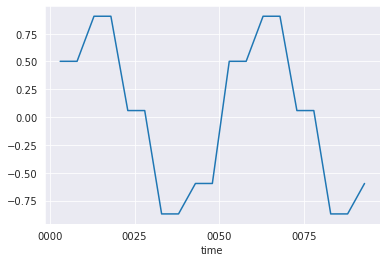

In [1003]:
signal_da_mean_res.resample(time='5Y').mean().plot()

In [1009]:
signal_da.resample(time='10Y').mean().time

<xarray.DataArray 'time' (time: 11)>
array([cftime.DatetimeNoLeap(0, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(10, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(20, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(30, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(40, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(50, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(60, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(70, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(80, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(90, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(100, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 0100-12-31 00:00:00

99

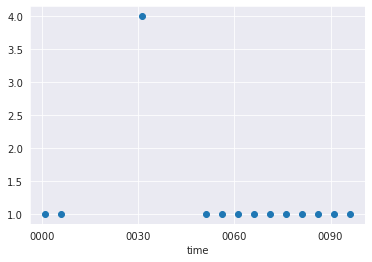

In [1041]:
test_time=xr.cftime_range(start='0000',end='0100',freq='Y',calendar='365_day')
vals=np.ones(len(test_time))
for i, ii in enumerate(vals):
    if i%5!=0:
        vals[i]=np.nan

vals[10:30]=np.nan
vals[30]=4
vals[31:50]=np.nan

test_da=xr.DataArray(vals,coords=dict(time=test_time))
test_da.plot.line('o')


/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, method=method, tolerance=tolerance)
/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, method=method, tolerance=tolerance)


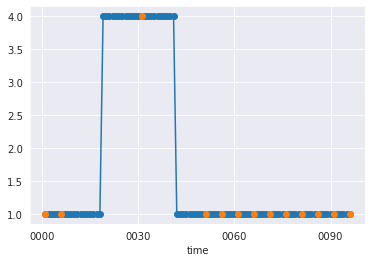

In [1045]:
test_da.dropna('time').resample(time='Y').interpolate('nearest').plot.line('o-')
test_da.plot.line('o')

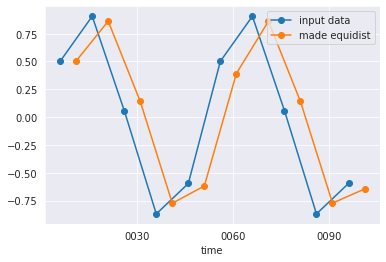

In [1017]:
signal_da_mean.plot.line('o-',label='input data')
#adapt equidistant p


made_equi.plot.line('o-',label='made equidist')
plt.legend()

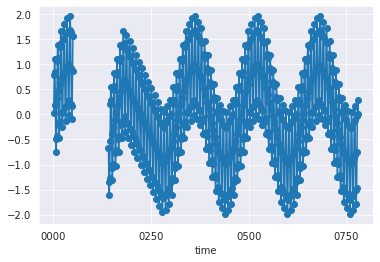

In [914]:
time_to_nan=data.isel(time=slice(50,140)).time

data_nan=data.copy()
data_nan.loc[dict(time=time_to_nan)]=np.nan
data_nan.plot.line('o-')

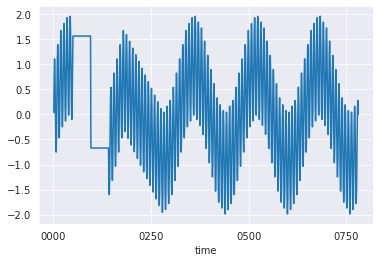

In [919]:
data_nan.interpolate_na('time','nearest').plot()

In [427]:
# One way to look for nans in the resampled TS:

# Resample original time_series to Final Time-Series -> Missing data are marked as nans 
# in these nans mark these ones, that are too far away from non nans -> these values are then masked in the resampled TS
data_nan_res=data_nan.resample(time='5Y').mean()

nan_times=data_nan_res.where(data_nan_res.isnull()==True,drop=True).time

/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, method=method, tolerance=tolerance)
/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, method=method, tolerance=tolerance)


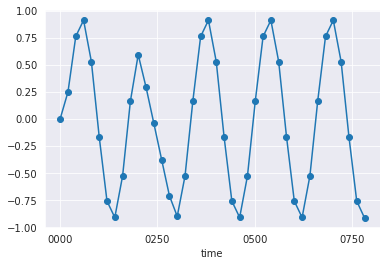

In [1273]:
data_res_fin=make_equidistant(signal_da_5_res+signal_hf, min_ts=1, target=20)
data_res_fin.plot.line('o-')

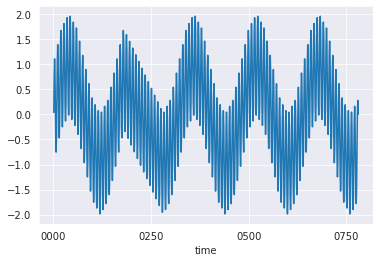

In [384]:
(signal_da_5_res+signal_hf).plot()



/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, method=method, tolerance=tolerance)
/home/ldap-server/draco/miniconda3/envs/paleoda_clean/lib/python3.10/site-packages/xarray/coding/cftimeindex.py:469: FutureWarning: Passing method to CFTimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return pd.Index.get_loc(self, key, method=method, tolerance=tolerance)


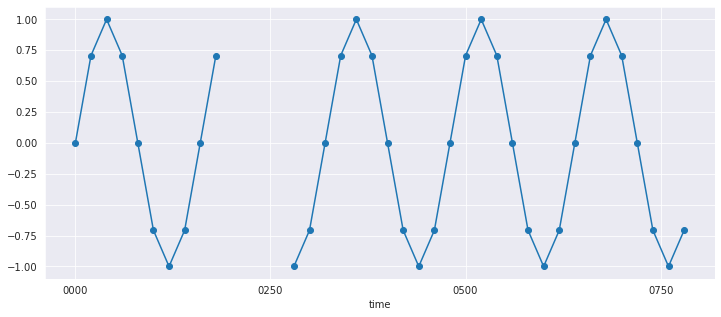

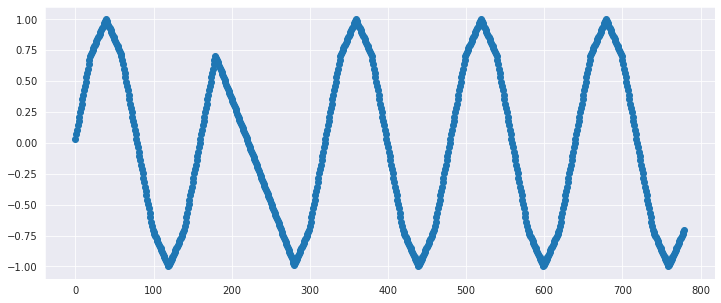

In [385]:
period=160
base_res=20
freq=1/base_res
time_y=np.arange(0,800,base_res)

#sinus signal has 1/20

signal_y=np.sin(2*np.pi*(1/period)*time_y)
signal_y[10:14]=np.nan

#resample with 10 times the resolution
time=xr.cftime_range(start='0000',end='0780',freq='20YS',calendar='365_day')

signal_da=xr.DataArray(data=signal_y,coords=dict(time=time))

plt.figure(figsize=(12,5))
signal_da.plot.line('o-')

signal_da_5_res=signal_da.resample(time='Y').interpolate('linear')
signal_da_5_res=signal_da_5_res.interpolate_na(dim='time',method='linear')

plt.show()
plt.figure(figsize=(12,5))
plt.plot(signal_da_5_res,'o-')

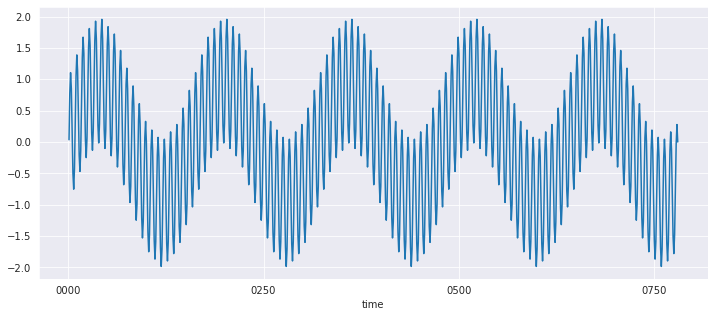

In [341]:
tt=np.arange(len(signal_da_5_res))
period=8
signal_hf=np.sin(2*np.pi/period*tt)
plt.figure(figsize=(12,5))
(signal_da_5_res+signal_hf).plot()

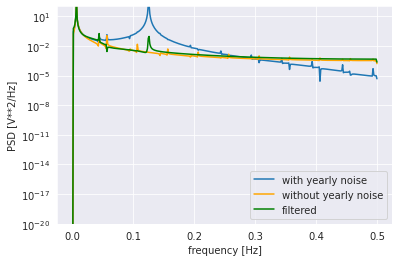

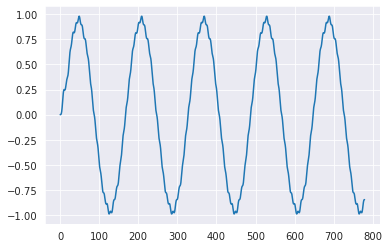

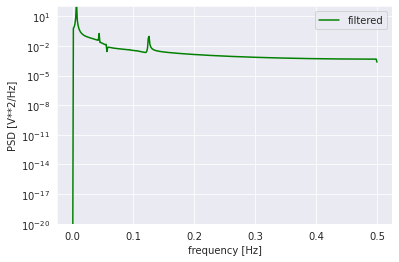

In [343]:
rng = np.random.default_rng(seed=42)

#noisy_5_res=(signal_da_5_res+rng.normal(size=len(signal_da_5_res))*0.5)[:-1]
noisy_5_res=(signal_da_5_res+signal_hf)[:-1]

fs=1
f, Pxx_den=signal.periodogram(noisy_5_res.values, fs)
plt.semilogy(f, Pxx_den,label='with yearly noise')
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')


fs=1
f, Pxx_den=signal.periodogram(signal_da_5_res.dropna('time'), fs)
plt.semilogy(f, Pxx_den,c='orange',label='without yearly noise')
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()

#### Filter the blue curve

mean=np.nanmean(noisy_5_res)
y=noisy_5_res.values-mean
#? Cutoff unclear? Should be 5 years if my basic resolution is 5
cutoff=1/20
#frequence of resampled
fs=1

order=4
# Filtering and plotting
filt = butter_lowpass_filter(y, cutoff, fs, order)
filt_new = filt + mean

fs=1
f, Pxx_den=signal.periodogram(filt_new, fs)
plt.semilogy(f, Pxx_den,c='green',label='filtered')
plt.ylim([1e-20, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()


plt.show()

plt.plot(filt)
plt.show()

fs=1
f, Pxx_den=signal.periodogram(filt_new, fs)
plt.semilogy(f, Pxx_den,c='green',label='filtered')
plt.ylim([1e-20, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()


plt.show()


In [350]:
time_new=signal_da_5_res.time[:-1]
filt_new_da=xr.DataArray(data=filt_new,coords=dict(time=time_new))

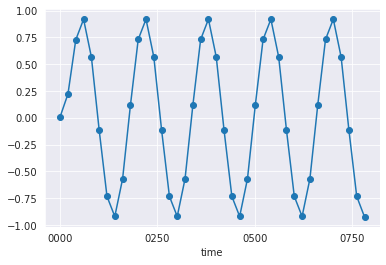

In [357]:
###### UPSAMPLE TO BASIC RESOLUTION
filt_new_da.resample(time='20Y').mean().plot.line('o-')


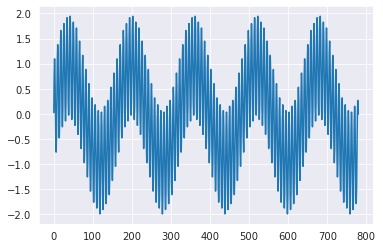

In [345]:
#unfiltered time-series
plt.plot(y)